Inicializacja wielowymiarowej liczby dualnej

In [6]:
struct Dual{T <:Number} <: Number
    v::T
    dv::Vector{T}
end


Rozmiar chunka -> długości wektora dv

In [7]:
chunk_leng=10

10

Załadowanie danych uczacych i testujących

In [8]:
using MLDatasets

# load full training set
train_x = MNIST.testtensor(Float64)
train_y = MNIST.testlabels()

# load full test set
test_x,  test_y  = MNIST.testdata()

(FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

...

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

FixedPointNumbers.Normed{UInt8,8}[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N

Operacje na liczbach dualnych

In [9]:
import Base: +, -, *, /
-(x::Dual) = Dual(-x.v,-x.dv)
+(x::Dual, y::Dual) = Dual( x.v + y.v, x.dv + y.dv)
-(x::Dual, y::Dual) = Dual( x.v - y.v, x.dv - y.dv)
+(x::Dual, y::Number) = Dual( x.v + y, x.dv)
-(x::Number, y::Dual) = Dual( y.v - x, y.dv)
+(x::Number, y::Dual) = Dual( y.v + x, y.dv)
-(x::Dual, y::Number) = Dual( x.v - y, x.dv)
*(x::Dual, y::Dual) = Dual( x.v * y.v, x.dv.* y.v + x.v.* y.dv)
*(x::Dual, y::Number) = Dual( x.v * y, x.dv.* y)
/(x::Dual, y::Dual) = Dual( x.v / y.v, (x.dv * y.v - x.v * y.dv)/y.v^2)
/(x::Dual, y::Number) = Dual( x.v / y, x.dv/y)
*(x::Number, y::Dual) = Dual( y.v * x, y.dv * x)
/(x::Number, y::Dual) = Dual( y.v / x, y.dv/x)


import Base: abs, sin, cos, tan, exp, sqrt, isless
abs(x::Dual) = Dual(abs(x.v),sign(x.v)*x.dv)
sin(x::Dual) = Dual(sin(x.v), cos(x.v)*x.dv)
cos(x::Dual) = Dual(cos(x.v),-sin(x.v)*x.dv)
tan(x::Dual) = Dual(tan(x.v), one(x.v)*x.dv + tan(x.v)^2*x.dv)
exp(x::Dual) = Dual(exp(x.v), exp(x.v)*x.dv)
sqrt(x::Dual) = Dual(sqrt(x.v),.5/sqrt(x.v) * x.dv)
isless(x::Dual, y::Dual) = x.v < y.v;

import Base: show
show(io::IO, x::Dual) = print(io, "(", x.v, ") + [", x.dv, "ϵ]");
value(x::Dual) = x.v;
partials(x::Dual) = x.dv;

import Base: convert, promote_rule

convert(::Type{Dual{T}}, x::Dual) where T =
Dual(convert(T, x.v), convert(Vector{T}, x.dv))

convert(::Type{Dual{T}}, x::Number, len::Number) where T =
Dual(convert(T, x), zeros(T,len))

convert(::Type{Dual{T}}, x::Number) where T =
Dual(convert(T, x), zeros(T,chunk_leng))

promote_rule(::Type{Dual{T}}, ::Type{R}) where {T,R} =
Dual{promote_type(T,R)}


promote_rule (generic function with 141 methods)

Jakobian dla liczb wielowymiarowych. Różniczkowanie w przód.

In [20]:
J = function jacobian(f, chunk_leng, args::Vector{T}) where {T <:Number}
    jacobian_columns = Matrix{T}[]
    for i=1:ceil(length(args)/chunk_leng)
        x = Dual{T}[]
        for j=1:length(args)
            seed = (j > (i-1) * chunk_leng && j <= i*chunk_leng)
            if seed
                oney = zeros(Float64, chunk_leng)
                index = mod(j -1, chunk_leng)
                oney[index + 1] = 1
                push!(x, Dual(args[j], oney))
            else
                push!(x, Dual(args[j], zeros(Float64, chunk_leng)))
            end
        end
        column = partials.(f(x)...)
        push!(jacobian_columns, column[:,:])
    end
    hjacobian = hcat(jacobian_columns...)
    return hjacobian
end

jacobian (generic function with 1 method)

Algorytm optymalizacyjny -> Algorytm Adagrad

In [11]:
abstract type DescentMethod end
struct GradientDescent <: DescentMethod
 α # learning rate
end

In [12]:
mutable struct Adagrad <: DescentMethod
 α # learning rate
 ϵ # small value
 s # sum of squared gradient
 Adagrad() = new() # new uninitialized structure
end

function init!(M::Adagrad, θ, α=0.01, ϵ=1e-8)
 M.α = α
 M.ϵ = ϵ
 M.s = zero(θ)
 return M
end

init! (generic function with 3 methods)

Inicjalizacja dwóch warstw sieci.

In [13]:
Wh= randn(30, 784)
Wo= randn(1, 30)

1×30 Array{Float64,2}:
 0.445988  1.09816  0.46438  -0.331967  …  0.670426  0.11826  0.327611

In [130]:
dense(w, n, m, v, f) = f.(reshape(w, n, m) * v)
mean_squared_loss(y, ŷ) = sum(0.5(y - ŷ).^2)
σ(x)= one(x) / (one(x) + exp(-x))
linear(x) = x

y_pred = []
dWh = similar(Wh)
dWo = similar(Wo)
step_val = similar(Wh)
step_val = similar(Wo)

x_conv = Array{Dual{Float64}}(undef, 784, 1) 
E = Float64[]

function net(x, wh, wo, y, chun_len)
    d =reshape(wh, 30,784)
    x̂ = dense(d, 30, 784, x, linear)
    ŷ = dense(wo, 1, 30, x̂ , σ)
    push!(y_pred, ŷ)
    E = mean_squared_loss.(y, ŷ)
    return E
end
dnet_Wh(x, wh, wo, y) = J(w -> net(x, w, wo, y, chunk_leng), chunk_leng, wh);
dnet_Wo(x, wh, wo, y) = J(w -> net(x, wh, w, y, chunk_leng), chunk_leng, wo); 
epochs = 100

x = train_x[:,:,1]
m = Adagrad()
Mh = init!(m, Wh)
m1 = Adagrad()
Mo = init!(m1, Wo)

for i=1:epochs
    x = train_x[:,:,i]
    x = x[:]
    y = train_y[i, :]
    dWh[:] = dnet_Wh(x, Wh[:], Wo[:], y)
    dWo[:] = dnet_Wo(x, Wh[:], Wo[:], y)
    
    α, ϵ, s, g = Mh.α, Mh.ϵ, Mh.s, dWh
    s += g.*g
    Mh.s = s
    step_val = - α*g ./ (sqrt.(s) .+ ϵ)
    Wh = Wh - step_val
    
    oα, oϵ, os, og = Mo.α, Mo.ϵ, Mo.s, dWo
    os += og.*og
    Mo.s = os
    step_valo = - oα*og ./ (sqrt.(os) .+ oϵ)
    Wo = Wo - step_valo
    
    Ei = net(x, Wh[:], Wo[:], y, chunk_leng)
    push!(E, Ei[1])
end
    

Testy

In [131]:
y_predicted_list = Int64[]

0-element Array{Int64,1}

In [132]:
dense(w, n, m, v, f) = f.(reshape(w, n, m) * v)
mean_squared_loss(y, ŷ) = sum(0.5(y - ŷ).^2)
σ(x)= one(x) / (one(x) + exp(-x))
linear(x) = x

function net(x, wh, wo, y)
    x̂ = dense(wh, 30, 784, x, σ)
    ŷ = dense(wo, 1, 30, x̂ , linear)
    E = mean_squared_loss(y, ŷ[1])
    return ŷ, E
end

test_len = 100
for i=1:test_len
    x = test_x[:,:,i]
    x = x[:]
    y = test_y[i]
    y_predicted, Ei = net(x, Wh[:], Wo[:], y)
#     println("oczekiwana wartość:", y, "co wyszło:", y_predicted[1])
    push!(y_predicted_list, round(Int64,y_predicted[1]))
end
println(y_predicted_list)

[3, -2, -1, -4, -3, -3, -2, -4, -5, 4, -5, 0, -2, -2, -2, -7, -5, 1, -4, -3, 4, -9, -5, -7, -7, -6, 4, -4, -3, -4, -5, -4, -6, -4, 1, -9, -3, -5, -2, -3, -4, 3, -4, -3, -4, -7, -8, -3, -9, -3, -5, 0, -5, -1, -7, -3, -6, -3, -3, 5, 0, 0, -4, 0, -1, -1, -6, -3, -6, -4, 7, -6, -4, -7, -5, -5, -4, 0, 3, 2, -2, -5, -2, -6, -6, -5, -2, -4, 0, -1, -6, -1, -3, -8, -6, -8, -8, -5, -5, -3]


[7 3; 2 -2; 1 -1; 0 -4; 4 -3; 1 -3; 4 -2; 9 -4; 5 -5; 9 4; 0 -5; 6 0; 9 -2; 0 -2; 1 -2; 5 -7; 9 -5; 7 1; 3 -4; 4 -3; 9 4; 6 -9; 6 -5; 5 -7; 4 -7; 0 -6; 7 4; 4 -4; 0 -3; 1 -4; 3 -5; 1 -4; 3 -6; 4 -4; 7 1; 2 -9; 7 -3; 1 -5; 2 -2; 1 -3; 1 -4; 7 3; 4 -4; 2 -3; 3 -4; 5 -7; 1 -8; 2 -3; 4 -9; 4 -3; 6 -5; 3 0; 5 -5; 5 -1; 6 -7; 0 -3; 4 -6; 1 -3; 9 -3; 5 5; 7 0; 8 0; 9 -4; 3 0; 7 -1; 4 -1; 6 -6; 4 -3; 3 -6; 0 -4; 7 7; 0 -6; 2 -4; 9 -7; 1 -5; 7 -5; 3 -4; 2 0; 9 3; 7 2; 7 -2; 6 -5; 2 -2; 7 -6; 8 -6; 4 -5; 7 -2; 3 -4; 6 0; 1 -1; 3 -6; 6 -1; 9 -3; 3 -8; 1 -6; 4 -8; 1 -8; 7 -5; 6 -5; 9 -3]


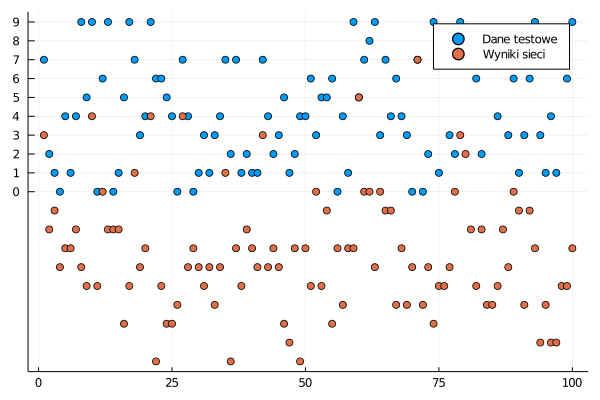

In [133]:
using Plots
x = 1:length(E)
y = test_y[1:100]
y_data = hcat(y, y_predicted_list)
println(y_data)
plot(x,y_data, yticks = 0:1:10, seriestype = :scatter, label = ["Dane testowe" "Wyniki sieci"], lw = 10)

Błąd w kolejnych iteracjach podczas uczenia.

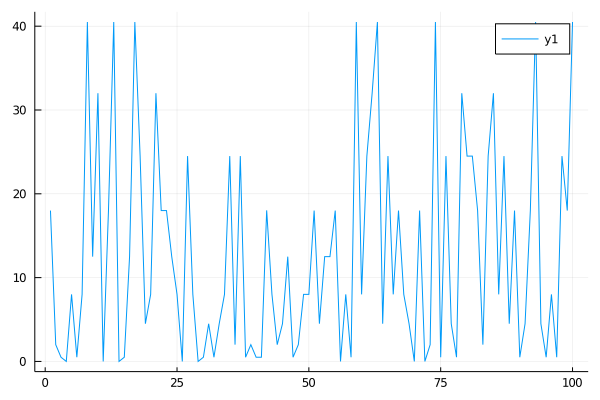

In [134]:
using Plots
x = 1:length(E)
plot(x,E)